# FemEc: Exploratory analysis

Female economists on the network.

In [1]:
# Load libraries
import os

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')

In [2]:
DATA = '/home/rdora/femec/data/processed/'

## Articles and people

Let us first take a look at the articles and the authors.

In [89]:
article = pd.read_csv(os.path.join(DATA, "article.csv"))

people = pd.read_csv(os.path.join(DATA, "people.csv"))

In [5]:
print(article.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673580 entries, 0 to 673579
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Author-Handle          673580 non-null  object 
 1   Short-Id               673580 non-null  object 
 2   handle                 673580 non-null  object 
 3   year                   671907 non-null  float64
 4   journal                673580 non-null  object 
 5   name                   673007 non-null  object 
 6   title                  667755 non-null  object 
 7   Workplace-Institution  518960 non-null  object 
 8   gender                 572441 non-null  object 
dtypes: float64(1), object(8)
memory usage: 46.3+ MB
None


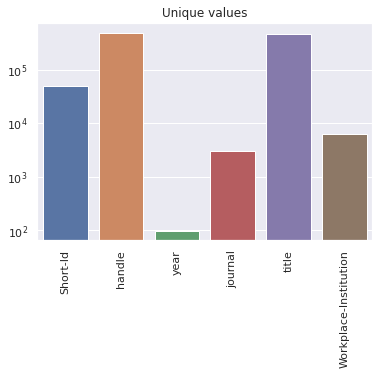

In [19]:
article_unique = article.drop(['Author-Handle', 'name', 'gender'], axis=1).nunique()

g = sns.barplot(x=article_unique.index, y=article_unique.values)
g.set(yscale='log', title='Unique values')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Gender distribution

In the articles table.

In [6]:
print(f"People (total: {people['Short-Id'].nunique():,})\n", people.gender.value_counts(normalize=True))

print(f"Articles (total: {article.handle.nunique():,})\n", article.gender.value_counts(normalize=True))

People (total: 58,671)
 male      0.732679
female    0.267321
Name: gender, dtype: float64
Articles (total: 489,091)
 male      0.839866
female    0.160134
Name: gender, dtype: float64


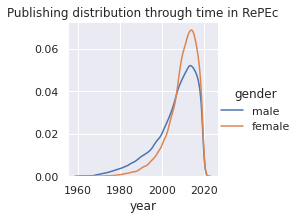

In [8]:
g = sns.FacetGrid(article[article.year > 1960], hue='gender')
g = (g.map(sns.distplot, "year", hist=False))
g.set(title="Publishing distribution through time in RePEc")
g.add_legend();

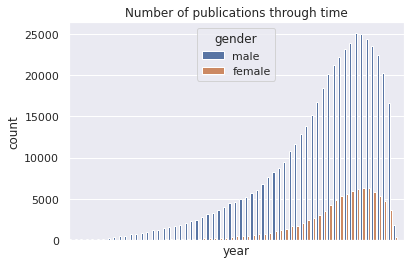

In [9]:
g = sns.countplot(x="year", hue="gender", data=article[article.year > 1960])
g.set(title="Number of publications through time")
g.set_xticks([]);

## Co-author network

Basic network parameters.

In the network, an edge $e = uv$ exists if $u$ and $v$ are co-authors.

In [10]:
co = pd.read_csv(os.path.join(DATA, 'co_author.csv'))

## Gender network

We'll start by exploring the gender distribution.

In [11]:
co = pd.merge(co, people.rename(columns={'Short-Id': 'author1', 'gender': 'gender1'})[['author1', 'gender1']],
              how='left', on='author1')

co = pd.merge(co, people.rename(columns={'Short-Id': 'author2', 'gender': 'gender2'})[['author2', 'gender2']],
              how='left', on='author2')

In [12]:
co_gender = co.dropna()

In [13]:
co_gender['gender_edge'] = co_gender['gender1'] + "-" + co_gender['gender2']

co_gender['gender_edge'].replace({'female-male': 'male-female'}, inplace=True)

/home/rdora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rdora/.local/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


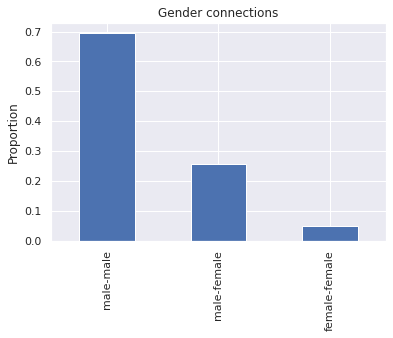

In [14]:
co_gender.gender_edge.value_counts(normalize=True).plot(kind='bar').set(title='Gender connections', ylabel="Proportion");

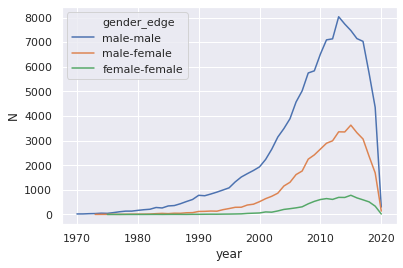

In [16]:
# Group by type of edge and plot
edge_info = co_gender.groupby(
    ['year', 'gender_edge'])['author1'].count().reset_index().rename(columns={'author1': 'N'})
sns.lineplot(x='year', y='N', hue='gender_edge', data=edge_info[edge_info.year >= 1970]);

In [17]:
genders = dict(zip(people['Short-Id'], people['gender']))

### Take a look at the actual network

So far, we've been looking at the edgelist.

In [18]:
G = nx.from_pandas_edgelist(co_gender,
                           source='author1',
                           target='author2')

In [19]:
nx.set_node_attributes(G, genders, name='gender')

In [20]:
print(f"Number of nodes: {len(G):,}\nNumber of edges: {len(G.edges):,}")

Number of nodes: 31,633
Number of edges: 82,005


In [21]:
print(f"Gender assortativity coefficient: {nx.attribute_assortativity_coefficient(G, 'gender'):.2f}")

print(f"Degree Assortativity coefficient: {nx.degree_assortativity_coefficient(G):.2f}")

print(f"Number of connected components: {nx.number_connected_components(G):,}")

print(f"Size of largest CC: {[len(c) for c in nx.connected_components(G)][0]:,}")

print(f"Size of largest 2--10 CC: {[len(c) for c in nx.connected_components(G)][1:10]}")

Gender assortativity coefficient: 0.11
Degree Assortativity coefficient: 0.16
Number of connected components: 960
Size of largest CC: 29,292
Size of largest 2--10 CC: [5, 3, 2, 5, 2, 2, 2, 2, 2]


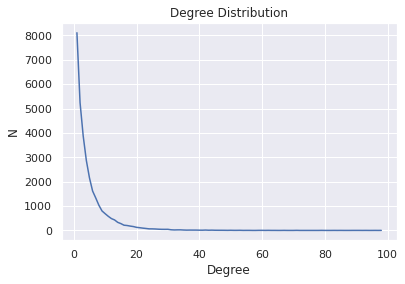

In [22]:
# Degree distribution
X = nx.degree_histogram(G)
g = sns.lineplot(x=range(1, len(X)), y=X[1:])

g.set(xlabel="Degree", ylabel="N", title="Degree Distribution");

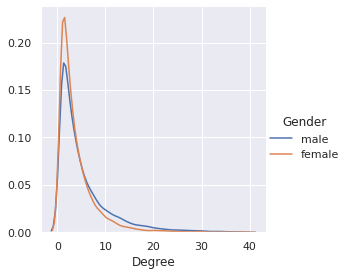

In [26]:
# Degree distribution by gender
g = sns.FacetGrid(hue='Gender', data=X[X.Degree < 40], height=4)
g.map(sns.distplot, 'Degree', hist=False)
g.add_legend();

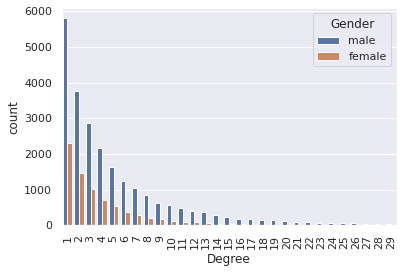

In [24]:
# Degree by gender
X = [[d, G.nodes[n]['gender']] for n, d in G.degree]
X = pd.DataFrame(X, columns=['Degree', 'Gender'])

sns.countplot(x='Degree', hue='Gender', data=X[X.Degree<30])
plt.xticks(rotation=90);

## Geographic network

By workplace.

In [27]:
# Add workplace information to the people table to
# then add it to the co-author network.
co = pd.read_csv(os.path.join(DATA, 'co_author.csv'))

workplace = pd.read_csv(os.path.join(DATA, 'institution.csv'))

people = people.rename(columns={'Workplace-Institution': 'workplace'})

workplace = workplace.rename(columns={'Handle': 'workplace'})[['workplace', 'alpha-3', 'region', 'sub-region']]

people = pd.merge(people, workplace, on='workplace', how='left')

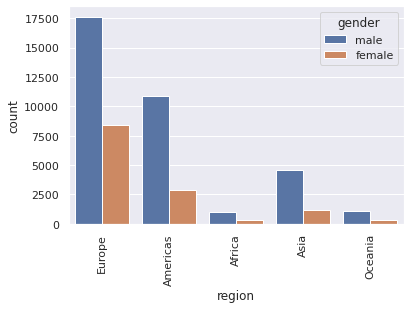

In [39]:
sns.countplot(x='region', hue='gender', data=people)
plt.xticks(rotation=90);

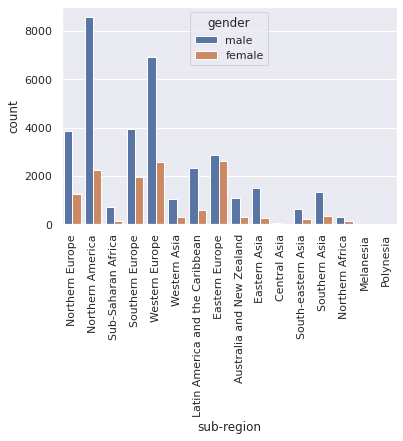

In [36]:
sns.countplot(x='sub-region', hue='gender', data=people)
plt.xticks(rotation=90);

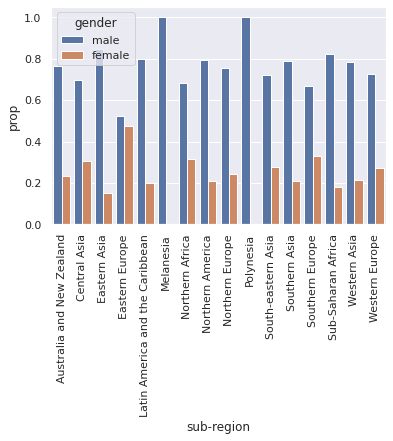

In [62]:
# Proportions
x, y, hue = 'sub-region', 'prop', 'gender'
prop_df = (people[hue]
           .groupby(people[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df, hue_order=['male', 'female'])
plt.xticks(rotation=90);

In [63]:
# Adding workplace information to the co_author network.
co_geo = pd.merge(co, people.rename(columns={
    'Short-Id': 'author1',
    'alpha-3': 'country1',
    'region': 'region1',
    'sub-region': 'sub_region1'})[['author1', 'country1', 'region1', 'sub_region1']],
              how='left', on='author1')

co_geo = pd.merge(co_geo, people.rename(columns={
    'Short-Id': 'author2',
    'alpha-3': 'country2',
    'region': 'region2',
    'sub-region': 'sub_region2'})[['author2', 'country2', 'region2', 'sub_region2']],
              how='left', on='author2')

In [64]:
co_geo = co_geo.drop(['journal_name', 'title'], axis=1).dropna()

countries = dict(zip(people['Short-Id'], people['alpha-3']))
regions = dict(zip(people['Short-Id'], people['region']))
subregions = dict(zip(people['Short-Id'], people['sub-region']))

### Let's look at the actual Geo network

In [65]:
G = nx.from_pandas_edgelist(co_geo,
                           source='author1',
                           target='author2',
                           edge_attr=['year', 'journal'])

nx.set_node_attributes(G, countries, name='country')
nx.set_node_attributes(G, regions, name='region')
nx.set_node_attributes(G, subregions, name='subregion')

In [66]:
for param in ['country', 'subregion', 'region']:
    print(f"{param} assortativity coefficient: {nx.attribute_assortativity_coefficient(G, param):.2f}")

country assortativity coefficient: 0.47
subregion assortativity coefficient: 0.51
region assortativity coefficient: 0.57


## Citation network

In [67]:
cites = pd.read_csv(os.path.join(DATA, 'cites.csv'))

In [68]:
cites['self_cite'] = False

In [69]:
cites.loc[(cites['target']==cites['source']), 'self_cite'] = True

In [70]:
# How many self-cites are they?
cites.self_cite.value_counts(normalize=True)

False    0.959042
True     0.040958
Name: self_cite, dtype: float64

## Gender network

In [71]:
cites = pd.merge(cites, people.rename(columns={'Short-Id': 'target', 'gender': 'gendert'})[['target', 'gendert']],
              how='left', on='target')

cites = pd.merge(cites, people.rename(columns={'Short-Id': 'source', 'gender': 'genders'})[['source', 'genders']],
              how='left', on='source')

In [72]:
cites = cites.dropna(subset=['gendert', 'genders'])

In [73]:
cites['gender_edge'] = cites['gendert'] + "-" + cites['genders']

cites['gender_edge'].replace({'female-male': 'male-female'}, inplace=True)

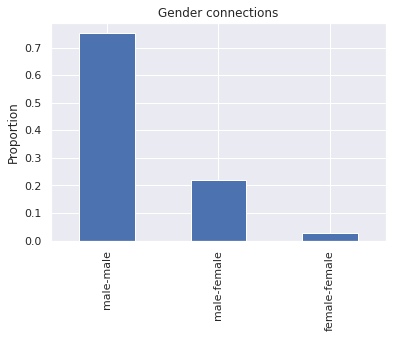

In [74]:
cites.gender_edge.value_counts(normalize=True).plot(kind='bar').set(title='Gender connections', ylabel="Proportion");

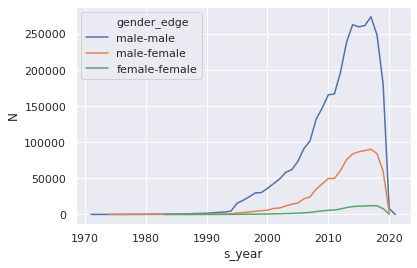

In [75]:
edge_info = cites.groupby(
    ['s_year', 'gender_edge'])['target'].count().reset_index().rename(columns={'target': 'N'})
sns.lineplot(x='s_year', y='N', hue='gender_edge', data=edge_info[edge_info.s_year >= 1970])

## Actual citation network

In [76]:
G = nx.from_pandas_edgelist(cites,
                           source='source',
                           target='target',
                           create_using=nx.DiGraph)

In [77]:
nx.set_node_attributes(G, genders, name='gender')

In [78]:
print(f"Number of connected components: {nx.number_weakly_connected_components(G):,}")

print(f"Size of largest CC: {[len(c) for c in nx.weakly_connected_components(G)][0]:,}")

print(f"Size of largest 2--10 CC: {[len(c) for c in nx.weakly_connected_components(G)][1:10]}")

Number of connected components: 97
Size of largest CC: 36,965
Size of largest 2--10 CC: [1, 1, 1, 1, 1, 1, 2, 1, 1]


In [79]:
print(f"Gender attribute assortativity: {nx.attribute_assortativity_coefficient(G, 'gender'):.2f}")

print(f"Degree attribute assortativity: {nx.degree_assortativity_coefficient(G, x='in', y='in'):.2f}")

Gender attribute assortativity: 0.04
Degree attribute assortativity: 0.03


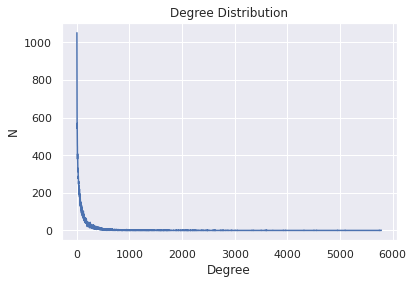

In [80]:
X = nx.degree_histogram(G)
g = sns.lineplot(x=range(1, len(X)), y=X[1:])
g.set(xlabel="Degree", ylabel="N", title="Degree Distribution");

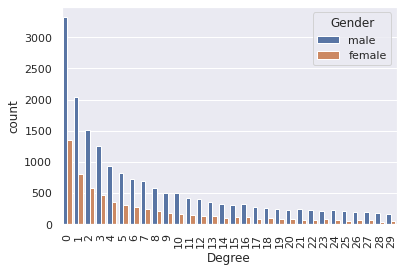

In [82]:
X = [[d, G.nodes[n]['gender']] for n, d in G.in_degree]
X = pd.DataFrame(X, columns=['Degree', 'Gender'])

sns.countplot(x='Degree', hue='Gender', data=X[X.Degree<30])
plt.xticks(rotation=90);

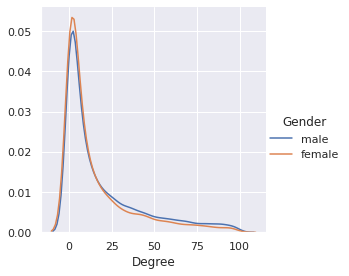

In [83]:
g = sns.FacetGrid(hue='Gender', data=X[X.Degree < 100], height=4)
g.map(sns.distplot, 'Degree', hist=False)
g.add_legend()

## Geographic network

In [84]:
cites = pd.read_csv(os.path.join(DATA, 'cites.csv'))

In [90]:
# Skip this if already done in gender network
cites = pd.read_csv(os.path.join(DATA, 'cites.csv'))

workplace = pd.read_csv(os.path.join(DATA, 'institution.csv'))

people = people.rename(columns={'Workplace-Institution': 'workplace'})

workplace = workplace.rename(columns={'Handle': 'workplace'})[['workplace', 'alpha-3', 'region', 'sub-region']]

people = pd.merge(people, workplace, on='workplace', how='left')

In [91]:
cites_geo = pd.merge(cites, people.rename(columns={
    'Short-Id': 'target',
    'alpha-3': 'country1',
    'region': 'region1',
    'sub-region': 'sub_region1'})[['target', 'country1', 'region1', 'sub_region1']],
              how='left', on='target')

cites_geo = pd.merge(cites_geo, people.rename(columns={
    'Short-Id': 'source',
    'alpha-3': 'country2',
    'region': 'region2',
    'sub-region': 'sub_region2'})[['source', 'country2', 'region2', 'sub_region2']],
              how='left', on='source')

In [92]:
cites_geo.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5801547 entries, 0 to 5801546
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   target       5801547 non-null  object 
 1   t_year       5800910 non-null  float64
 2   t_journal    5801547 non-null  object 
 3   source       5801547 non-null  object 
 4   s_year       5792548 non-null  float64
 5   s_journal    5801547 non-null  object 
 6   country1     4705825 non-null  object 
 7   region1      4705825 non-null  object 
 8   sub_region1  4705825 non-null  object 
 9   country2     4571062 non-null  object 
 10  region2      4571062 non-null  object 
 11  sub_region2  4571062 non-null  object 
dtypes: float64(2), object(10)
memory usage: 575.4+ MB


In [93]:
cites_geo = cites_geo.drop(['t_year', 't_journal', 's_year', 's_journal'], axis=1).dropna()

### Actual Geo citation network

In [94]:
G = nx.from_pandas_edgelist(cites_geo,
                           source='source',
                           target='target')

nx.set_node_attributes(G, countries, name='country')
nx.set_node_attributes(G, regions, name='region')
nx.set_node_attributes(G, subregions, name='subregion')

In [95]:
for param in ['country', 'subregion', 'region']:
    print(f"{param} assortativity coefficient: {nx.attribute_assortativity_coefficient(G, param):,.2f}")

country assortativity coefficient: 0.06
subregion assortativity coefficient: 0.07
region assortativity coefficient: 0.09
